## Download the images


We can use **GoogleDriveDownloader** form **google_drive_downloader** library in Python to download the shared files from the shared Google drive link: https://drive.google.com/file/d/1f7uslI-ZHidriQFZR966_aILjlkgDN76/view?usp=sharing

The file id in the above link is: **1f7uslI-ZHidriQFZR966_aILjlkgDN76**

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1f7uslI-ZHidriQFZR966_aILjlkgDN76',
                                    dest_path='content/eye_gender_data.zip',
                                    unzip=True)

Unzipping...Done.


We have all the files from the shared Google drive link downloaded in the colab environment.

## Loading Libraries
All Python capabilities are not loaded to our working environment by default (even they are already installed in your system). So, we import each and every library that we want to use.

We chose alias names for our libraries for the sake of our convenience (numpy --> np and pandas --> pd, tensorlow --> tf).

Note: You can import all the libraries that you think will be required or can import it as you go along.

In [17]:
import pandas as pd                                     # Data analysis and manipultion tool
import numpy as np                                      # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf                                 # Deep Learning Tool
import os                                               # OS module in Python provides a way of using operating system dependent functionality
import cv2                                              # Library for image processing
from sklearn.model_selection import train_test_split    # For splitting the data into train and validation set
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

## Loading and preparing training data


In [ ]:
labels = pd.read_csv("/content/content/eye_gender_data/Training_set.csv")   # loading the labels
file_paths = [[fname, '/content/content/eye_gender_data/train/' + fname] for fname in labels['filename']]
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
train_data = pd.merge(images, labels, how = 'inner', on = 'filename')

data = []     # initialize an empty numpy array
image_size = 32      # image size taken is 32 here. 

for i in range(len(train_data)):
  
  img_array = cv2.imread(train_data['filepaths'][i], cv2.IMREAD_GRAYSCALE)   # converting the image to gray scale
  new_img_array = cv2.resize(img_array, (image_size, image_size))      # resizing the image array
  data.append(new_img_array) 

## Data Pre-processing
It is necessary to bring all the images in the same shape and size, also convert them to their pixel values because all machine learning or deep learning models accepts only the numerical data. Also we need to convert all the labels from categorical to numerical values.

In [ ]:
arr = np.array(data)

In [4]:
arr

array([[[189, 188, 182, ..., 178, 177, 172],
        [187, 179, 179, ..., 175, 172, 162],
        [185, 181, 184, ..., 168, 157, 149],
        ...,
        [142, 136, 148, ..., 164, 162, 164],
        [140, 150, 161, ..., 169, 164, 164],
        [139, 154, 163, ..., 173, 167, 164]],

       [[170, 175, 172, ..., 190, 193, 194],
        [165, 152, 136, ..., 186, 189, 191],
        [147, 124, 107, ..., 183, 189, 193],
        ...,
        [188, 189, 190, ..., 191, 197, 202],
        [187, 190, 190, ..., 195, 197, 196],
        [186, 190, 190, ..., 200, 201, 197]],

       [[176, 172, 172, ..., 135, 128, 127],
        [168, 165, 165, ...,  91, 114, 111],
        [164, 165, 162, ...,  76,  62,  68],
        ...,
        [131, 143, 148, ..., 115, 112, 103],
        [131, 145, 150, ..., 113, 108,  99],
        [130, 144, 150, ..., 114, 106,  95]],

       ...,

       [[190, 175, 169, ..., 100, 115, 135],
        [177, 161, 147, ...,  83, 103, 101],
        [158, 138, 130, ...,  74,  72,  64

In [5]:
arr.shape

(9220, 32, 32)

In [6]:
# reshape into 3 channels for feeding into the model
train_images_3ch = np.stack([arr]*3, axis=-1)
print('\nTrain_images.shape: {}, of {}'.format(train_images_3ch.shape, train_images_3ch.dtype))


Train_images.shape: (9220, 32, 32, 3), of uint8


In [7]:
# normalisation
train_images_scaled = train_images_3ch / 255.

In [9]:
# encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_labels = le.fit_transform(train_data[['label']])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
train_labels.shape

(9220,)

## Building Model & Hyperparameter tuning
Now we are finally ready, and we can train the model.


In [12]:
# Build Cut-VGG19 Model

# define input shape
INPUT_SHAPE = (32, 32, 3)

# get the VGG19 model
vgg_layers = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, 
                                               input_shape=INPUT_SHAPE) 

vgg_layers.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
______________________________________________________________

In [13]:
# Fine-tune all the layers
for layer in vgg_layers.layers:
    layer.trainable = True 

# Check the trainable status of the individual layers
for layer in vgg_layers.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fbed9af9890> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fbed91b2e50> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fbed9065d50> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fbed583f410> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fbed5848310> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fbed5852210> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fbed583fdd0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fbed585b4d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fbed585ea50> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fbed585b910> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fbed586d510> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fbed57f4

In [14]:
# Build CNN model on top of VGG19

# define sequential model
model = tf.keras.models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_layers)

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) #single node with ‘sigmoid‘ activation to predict the probability for class 1.

# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# view model layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2

In [15]:
EPOCHS = 30

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, 
                                               restore_best_weights=True,
                                               verbose=1)

history = model.fit(train_images_scaled, train_labels,
                    batch_size=256,
                    callbacks=[es_callback], 
                    validation_split=0.1, epochs=EPOCHS, 
                    verbose=1)

Epoch 1/30
33/33 [==============================] - 1088s 33s/step - loss: 0.5558 - accuracy: 0.7135 - val_loss: 0.3897 - val_accuracy: 0.8308
Epoch 2/30
33/33 [==============================] - 1072s 32s/step - loss: 0.3501 - accuracy: 0.8539 - val_loss: 0.2842 - val_accuracy: 0.8872
Epoch 3/30
33/33 [==============================] - 1084s 33s/step - loss: 0.2495 - accuracy: 0.8994 - val_loss: 0.2498 - val_accuracy: 0.8970
Epoch 4/30
33/33 [==============================] - 1053s 32s/step - loss: 0.2033 - accuracy: 0.9219 - val_loss: 0.2447 - val_accuracy: 0.8948
Epoch 5/30
33/33 [==============================] - 1075s 33s/step - loss: 0.1706 - accuracy: 0.9359 - val_loss: 0.2280 - val_accuracy: 0.9132
Epoch 6/30
33/33 [==============================] - 1049s 32s/step - loss: 0.1453 - accuracy: 0.9455 - val_loss: 0.2107 - val_accuracy: 0.9252
Epoch 7/30
33/33 [==============================] - 1035s 31s/step - loss: 0.1448 - accuracy: 0.9467 - val_loss: 0.1989 - val_accuracy: 0.9219

## Validate the model


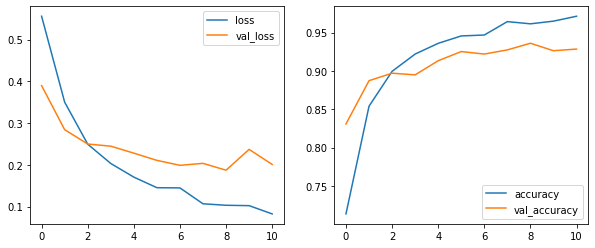

In [18]:
# Plot Learning Curves
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [19]:
# saving the model
save_dir = "/results/"
model_name = 'eye_model.h5'
model.save(model_name)
model_path = save_dir + model_name
print('Saved trained model at %s ' % model_path)

Saved trained model at /results/eye_model.h5 


## Predict The Output For Testing Dataset 😅
We have trained our model, evaluated it and now finally we will predict the output/target for the testing data (i.e. Test.csv).

#### Load Test Set
Load the test data on which final submission is to be made.

In [20]:
# refer to the instruction on word document
test_data = pd.read_csv("/content/content/eye_gender_data/Testing_set.csv" )

In [ ]:
file_paths_test = [[fname, '/content/content/eye_gender_data/test/' + fname] for fname in test_data['filename']]
images_test = pd.DataFrame(file_paths_test, columns=['filename', 'filepaths'])

new_test_data = []
#image_size = 32 

for i in range(len(images_test)):
  
  img_array_test = cv2.imread(images_test['filepaths'][i], cv2.IMREAD_GRAYSCALE)   # converting the image to gray scale
  new_img_array_test = cv2.resize(img_array_test, (image_size, image_size))      # resizing the image array
  new_test_data.append(new_img_array_test)

## Data Pre-processing on test_data


In [ ]:
test_arr = np.array(new_test_data)

In [29]:
test_arr

array([[[138, 140, 142, ..., 162, 167, 168],
        [140, 134, 137, ..., 159, 162, 161],
        [115, 131, 127, ..., 159, 158, 153],
        ...,
        [151, 164, 171, ..., 171, 159, 157],
        [147, 159, 165, ..., 166, 159, 154],
        [151, 160, 168, ..., 161, 150, 148]],

       [[163, 172, 156, ...,  84,  93,  85],
        [148, 158, 144, ...,  77,  75,  69],
        [136, 142, 128, ...,  67,  66,  68],
        ...,
        [114, 109, 108, ..., 129, 134, 144],
        [116, 119, 124, ..., 120, 134, 136],
        [112, 124, 123, ..., 120, 131, 122]],

       [[206, 200, 193, ..., 169, 176, 184],
        [205, 203, 186, ..., 171, 175, 180],
        [201, 202, 183, ..., 150, 156, 164],
        ...,
        [216, 218, 215, ..., 211, 214, 218],
        [215, 217, 218, ..., 215, 219, 222],
        [212, 217, 217, ..., 214, 220, 221]],

       ...,

       [[146, 149, 151, ..., 139, 142, 143],
        [150, 151, 155, ..., 139, 140, 140],
        [151, 150, 154, ..., 138, 139, 138

In [30]:
test_arr.shape

(2305, 32, 32)

In [31]:
# reshape into 3 channels for feeding into the model
test_images_3ch = np.stack([test_arr]*3, axis=-1)
print('\nTest_images.shape: {}, of {}'.format(test_images_3ch.shape, test_images_3ch.dtype))


Test_images.shape: (2305, 32, 32, 3), of uint8


In [32]:
# normalisation
test_images_scaled = test_images_3ch / 255.

### Make Prediction on Test Dataset
Time to make a submission!!!

In [33]:
test_predictions = model.predict(test_images_scaled)

In [53]:
images_test['predictprobability'] = test_predictions

In [59]:
def convert_to_label (row):
  if row['predictprobability'] >=0.5:
    return 'male'
  else:
    return 'female'

images_test['predictlabel'] = images_test.apply(convert_to_label, axis=1)

In [60]:
images_test.head()

,filename,filepaths,predictprobability,predictlabel
0,Image_1.jpg,/content/content/eye_gender_data/test/Image_1.jpg,0.998291,male
1,Image_2.jpg,/content/content/eye_gender_data/test/Image_2.jpg,0.958787,male
2,Image_3.jpg,/content/content/eye_gender_data/test/Image_3.jpg,0.989709,male
3,Image_4.jpg,/content/content/eye_gender_data/test/Image_4.jpg,0.985602,male
4,Image_5.jpg,/content/content/eye_gender_data/test/Image_5.jpg,0.999317,male


In [61]:
images_test.tail()

,filename,filepaths,predictprobability,predictlabel
2300,Image_2301.jpg,/content/content/eye_gender_data/test/Image_23...,0.005048,female
2301,Image_2302.jpg,/content/content/eye_gender_data/test/Image_23...,0.004770,female
2302,Image_2303.jpg,/content/content/eye_gender_data/test/Image_23...,0.999718,male
2303,Image_2304.jpg,/content/content/eye_gender_data/test/Image_23...,0.999712,male
2304,Image_2305.jpg,/content/content/eye_gender_data/test/Image_23...,0.943940,male


In [62]:
# How to save prediction results locally via colab notebook?

images_test.to_csv("submission.csv", index = False) 

# To download the csv file locally
from google.colab import files        
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Well Done! 👍**
You are all set to make a submission. Let's head to the **[challenge page](https://dphi.tech/challenges/4-week-deep-learning-online-bootcamp-final-assignment-sex-determination-by-morphometry-of-eyes/144/submit)** to make the submission.